In [1]:
import os, fnmatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from scipy.misc import imresize
import cv2

%matplotlib inline

target_size = (32,96) # aligning with pix per cell size 

def find_files(directory, pattern): # from stackoverflow
    for root, dirs, files in os.walk(directory):
        for basename in files:
            if fnmatch.fnmatch(basename, pattern):
                filename = os.path.join(root, basename)
                yield filename

def image_in_list(img):
    res = cv2.resize(img, target_size, interpolation = cv2.INTER_CUBIC)
    return res
        
def load_and_extract(directory, fn_handler, feature_list):
    shape = None        
    cnt = 0
    
    for filename in find_files(directory, '*.jpg'):
        cnt += 1
        img = plt.imread(filename)
        
        if len(img.shape) > 2 and img.shape[2] == 4:
            #converthe image from RGBA2RGB
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        
        img_2 = cv2.resize(img, target_size, interpolation = cv2.INTER_CUBIC)
             
        feature_list.append(fn_handler(img_2))
        

In [2]:

X_positive = []
X_negative = []

load_and_extract('positives/', image_in_list, X_positive)
load_and_extract('negatives', image_in_list, X_negative)

print("there are %d positive images and %d negative images" % (len(X_positive), len(X_negative)))


there are 907 positive images and 1177 negative images


In [3]:
from skimage.feature import hog
import cv2

def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel()

def convert_color(image, conv = 'YCrCb'):
    
    csd = {}
    csd['HSV'] = cv2.COLOR_RGB2HSV
    csd['HLS'] = cv2.COLOR_RGB2HLS
    csd['LUV'] = cv2.COLOR_RGB2LUV
    csd['YUV'] = cv2.COLOR_RGB2YUV
    csd['YCrCb'] = cv2.COLOR_RGB2YCrCb
    
    if cspace in csd:
        img = cv2.cvtColor(image, csd[cspace])
    else:
        img = np.copy(image)
        
    return img

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    hist_features = hist_features.astype(np.float32)
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        #print("hog features.shape: ", features.shape)
        return features

    
# assumption: All images are in RGB and not in BGR format
def extract_feature(image, cspace='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel = 'ALL', spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256)):
    #print("extract_features - image shape: ", image.shape)
    img = convert_color(image, conv=cspace)
    
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(img.shape[2]):
            hog_features.append(get_hog_features(img[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.hstack(hog_features)        
    else:
        hog_features = get_hog_features(img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
           
    spatial = bin_spatial(img, size=spatial_size)
    color_h = color_hist(img, nbins=hist_bins)
    color_h = []
    spatial = []
    
    feature = np.concatenate((spatial, color_h, hog_features))
    #feature = np.hstack((spatial, color_h, hog_features)).reshape(1, -1)
    
    return feature

orient = 11
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16,16)
hist_bins = 16
cspace = 'YCrCb'

extractor = lambda image: extract_feature(image, hog_channel='ALL', orient=orient, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins)
extr_mirr = lambda image: extract_feature(np.fliplr(image), hog_channel='ALL', orient=orient, cspace=cspace, spatial_size=spatial_size, hist_bins=hist_bins)

In [4]:
import time

X_positive = []
X_positive_m = []
X_negative = []
X_negative_m = []

t1 = time.time()

load_and_extract('positives/', extractor, X_positive)
load_and_extract('positives/', extr_mirr, X_positive_m)
load_and_extract('negatives/', extractor, X_negative)
load_and_extract('negatives/', extr_mirr, X_negative_m)

t2 = time.time()

print(round(t2-t1, 2), ' Seconds to compute features')


22.7  Seconds to compute features


In [5]:
#len(X_negative_mirrored)
#X_positive.extend(X_positive_m)

print("len X_positive:", len(X_positive), " len X_positive_m: ",  len(X_positive_m), " len X_negative: ", len(X_negative), " len X_negative_m: ", len(X_negative_m))

X_positive.extend(X_positive_m)
X_negative.extend(X_negative_m)

len X_positive: 907  len X_positive_m:  907  len X_negative:  1177  len X_negative_m:  1177


In [6]:
import numpy as np

X = np.vstack((X_positive, X_negative)).astype(np.float64)
y = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))

print(X.shape, y.shape)

(4168, 4356) (4168,)


In [7]:
# X, y ready for standardscaling, shuffling and traintestsplit

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#X = X.reshape((X.shape[0],X.shape[2]))
print(X.shape)

# Standardscaling

X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

# Shuffling is done in train_test_split

random_state = np.random.randint(1000)

X_scaled, y = shuffle(X_scaled, y, random_state = random_state)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=random_state)

svc = LinearSVC(C=0.01)
svc.fit(X_train, y_train)

(4168, 4356)


LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [8]:
svc.score(X_test, y_test)

1.0

In [9]:
# now with GridSearchCV
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC

#parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
#                {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

#parameters = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1]}]

#clf = GridSearchCV(SVC(), param_grid = parameters, scoring='precision_macro', n_jobs=4)
#clf.fit(X_train, y_train)
#print(clf.best_params_)

In [10]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_positives(img, ystart, ystop, scale, svc, X_scaler, cells_per_step, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    decitresh = 0.01
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    ctrans_tosearch = convert_color(img, conv=cspace)
    
    if scale != 1.:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    (window_x, window_y) = target_size
    
    nblocks_per_window_x = (window_x // pix_per_cell) - cell_per_block + 1
    nblocks_per_window_y = (window_y // pix_per_cell) - cell_per_block + 1
    
    #cells_per_step = 3  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window_x) // cells_per_step # x direction
    nysteps = (nyblocks - nblocks_per_window_y) // cells_per_step # y direction
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            # print("y blocks:", ypos, " bis: ", ypos+nblocks_per_window_y, "x blocks:", xpos, "bis ", xpos+nblocks_per_window_x)
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window_y, xpos:xpos+nblocks_per_window_x].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window_y, xpos:xpos+nblocks_per_window_x].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window_y, xpos:xpos+nblocks_per_window_x].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch and get color features
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window_y, xleft:xleft+window_x], target_size)         
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # some of these screw my vector up
            spatial_features = []
            hist_features = []
            
            feature_concat = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
             
            # Scale features
            test_features = X_scaler.transform(feature_concat)
            prediction = svc.predict(test_features)[0]
        
            if prediction == 1: 
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                #win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+np.int(window_x*scale), ytop_draw+ystart+np.int(window_y*scale))))
    
    return boxes
                             
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        ((x1,y1),(x2,y2)) = box
        heatmap[y1:y2,x1:x2] += 1
        
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_boxes(img, boxes):
    for b in boxes:
        cv2.rectangle(img, (b[0][0], b[0][1]), (b[1][0], b[1][1]),(0,0,255),6)
    return img

filenamecounter = 0

def save_img_in_boxes(img, boxes):
    global filenamecounter
    for b in boxes:
        fname = 'falsepositives/' + str(filenamecounter) + '.png'
        filenamecounter += 1
    
        image = img[b[0][1]:b[1][1], b[0][0]:b[1][0]]
        
        if image.shape[0] > 20 and image.shape[1] > 20:
        
            resized = cv2.resize(image, (64,64), interpolation=cv2.INTER_LINEAR)
            plt.imsave(fname, resized, format='png')



In [18]:
detector_params = [[0, 600-1 , 2, 2],[0, 600-1 , 1.5, 2],[0, 600-1 , 1., 2]]

debug = True

last_heat = None

def process_image(testimage, threshold = 4, debug = False, vis = True, detector_params=[]):
    global last_heat, X_scaler, svc, cspace, orient, pix_per_cell, spatial_size, hist_bins, cell_per_block
    
    # the current frame information goes into this_heat
    this_heat = np.zeros_like(testimage[:,:,0]).astype(np.float)
    # the current frame and the former is joined into heat then
    heat = np.zeros_like(testimage[:,:,0]).astype(np.float)

    for p in detector_params:
        ystart = p[0]
        ystop = p[1]
        scale = p[2]
        cell_per_step=p[3]

        boxes = find_positives(testimage, ystart, ystop, scale, svc, X_scaler, cell_per_step, cspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        add_heat(this_heat, boxes)
        
        if debug == True:
            save_img_in_boxes(testimage, boxes)

        if vis == True:
            fig = plt.figure(figsize=(16,8))
            plt.title(p)
            #draw_img = draw_labeled_bboxes(np.copy(testimage), labels)
            draw_img = draw_boxes(np.copy(testimage), boxes)
            plt.imshow(draw_img)
    
    # Take the heatmap of the last iteration
    #if last_heat != None:
    #    heat = this_heat + last_heat
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)
    #last_heat = np.copy(this_heat)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(this_heat, 0, 255)
    (h,w) = heatmap.shape[:2]
    
    hmsmall = cv2.resize(heatmap,(int(w/3),int(h/3)), cv2.INTER_AREA) * 5
    vv = np.dstack((hmsmall,hmsmall, hmsmall))
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(testimage, labels)
    
    draw_img[0:vv.shape[0],0:vv.shape[1]] = vv
    
    if vis == True:
        fig = plt.figure(figsize=(16,16))
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    
    return draw_img



/home/adolf/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


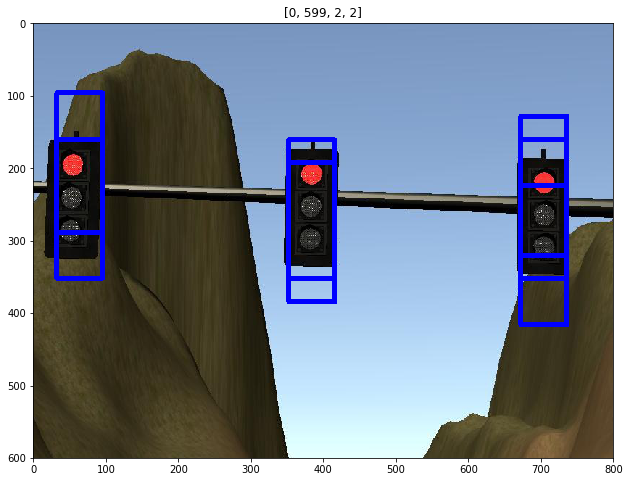

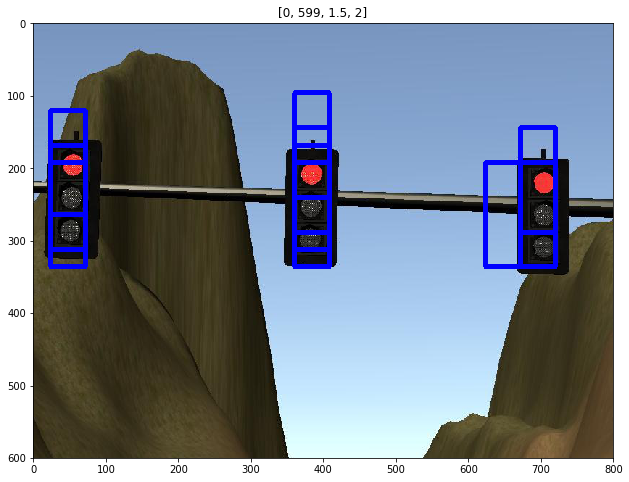

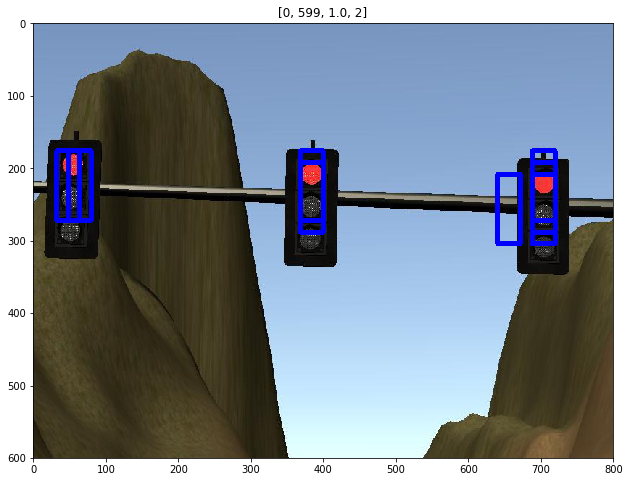

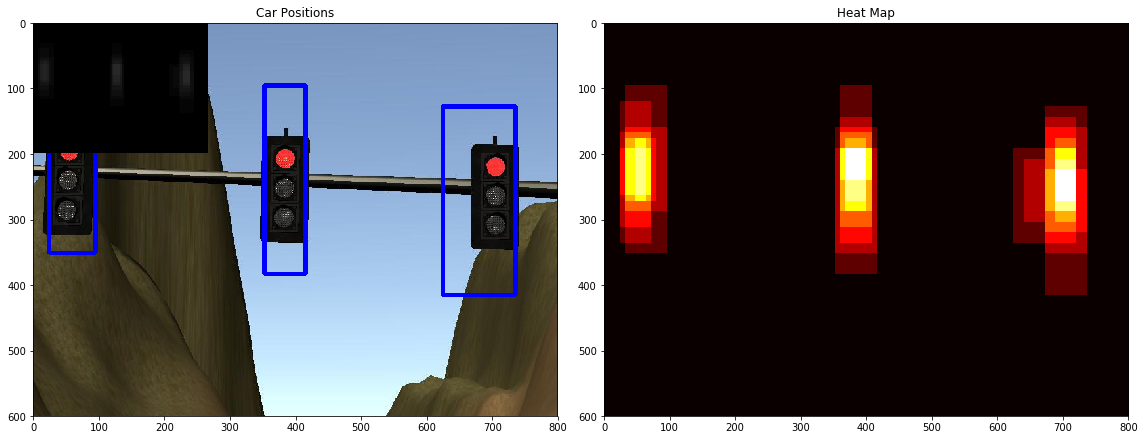

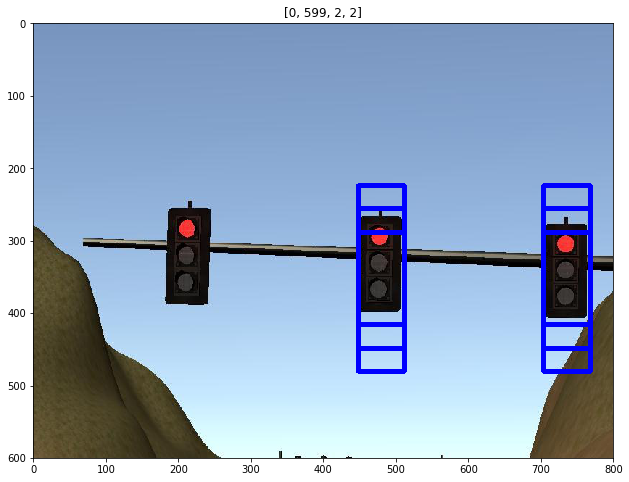

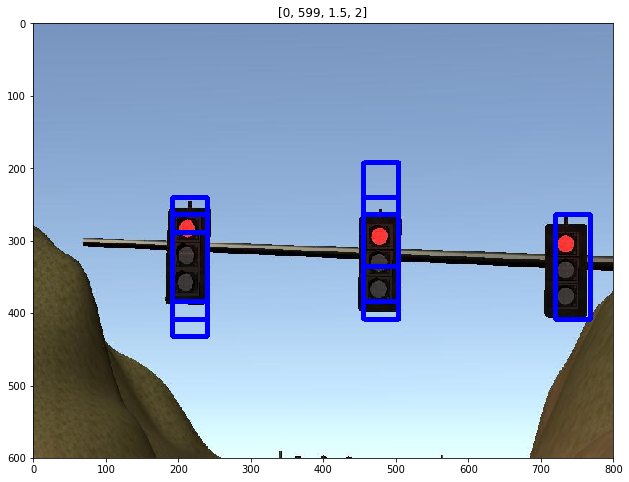

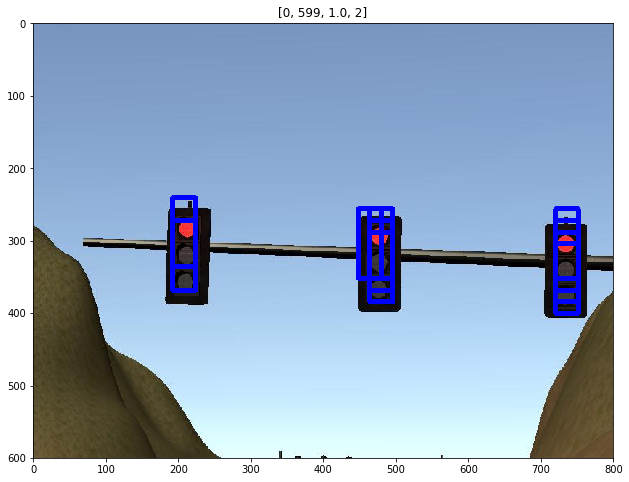

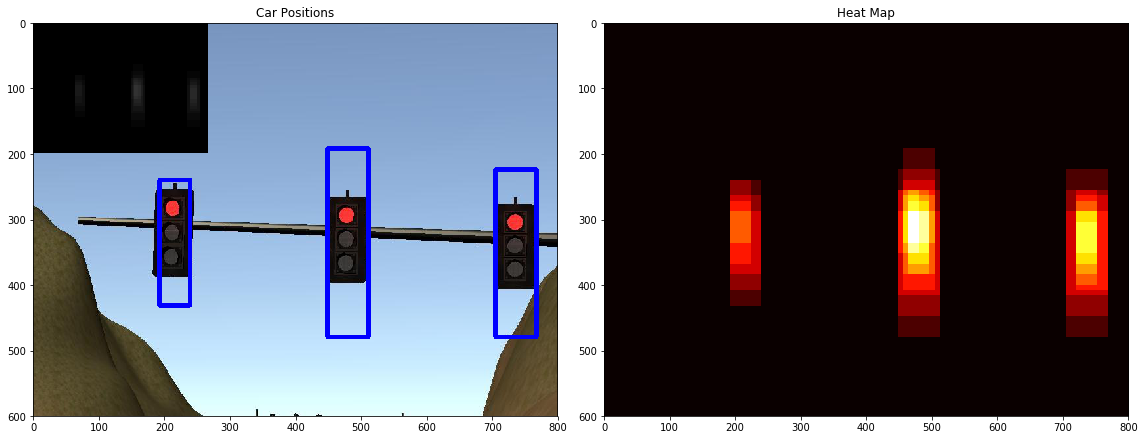

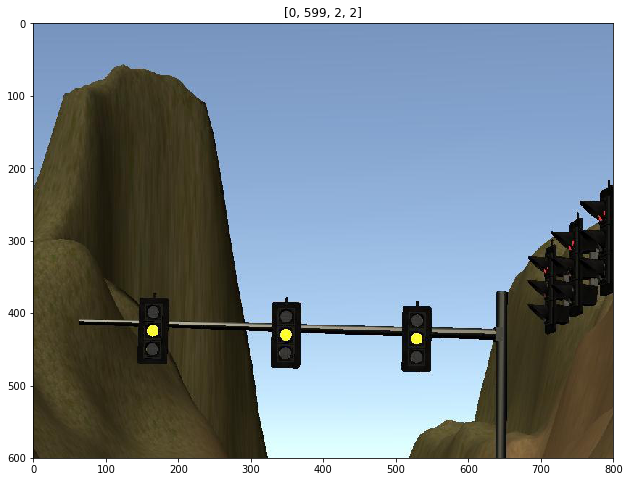

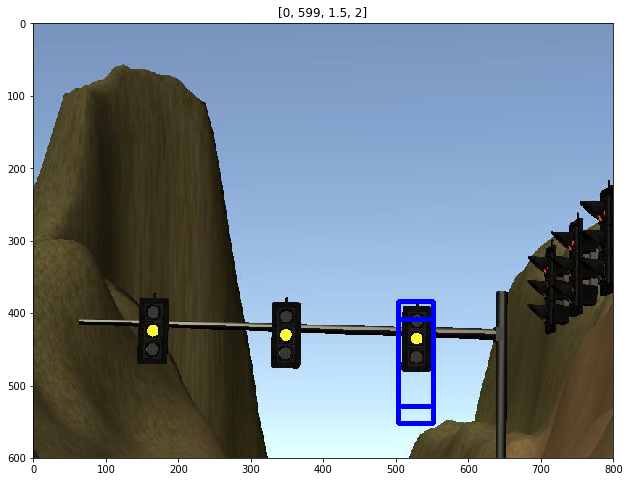

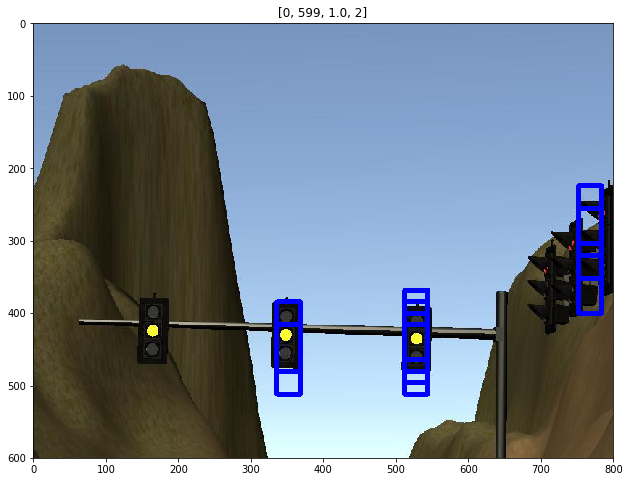

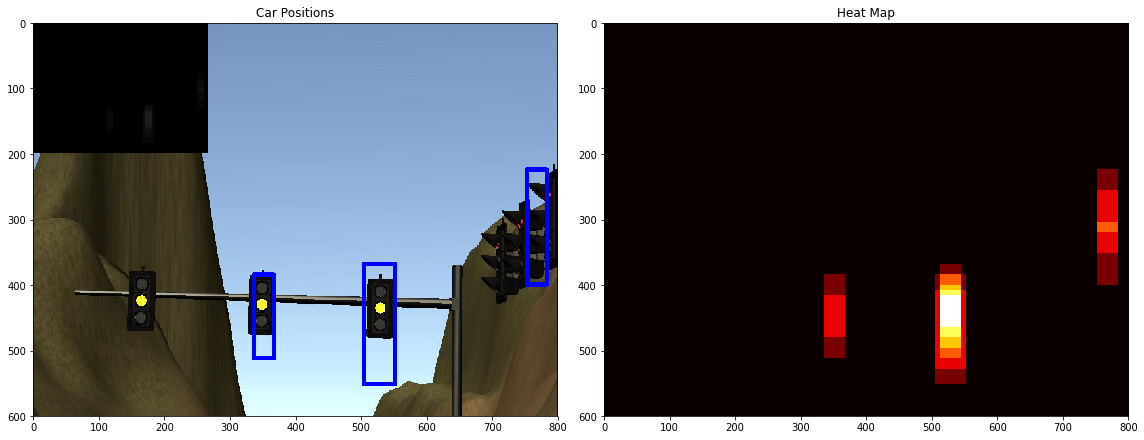

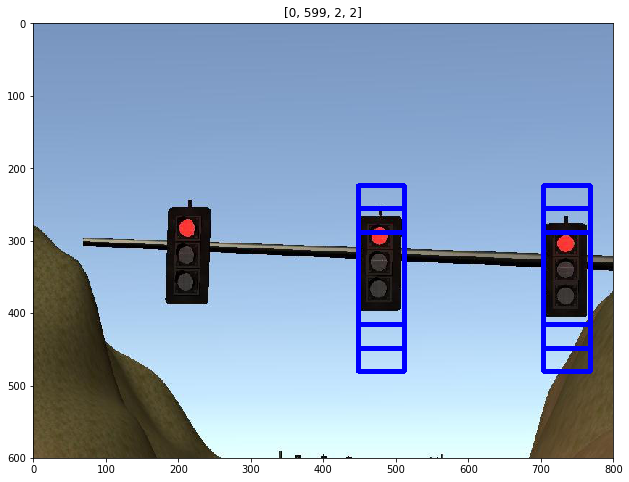

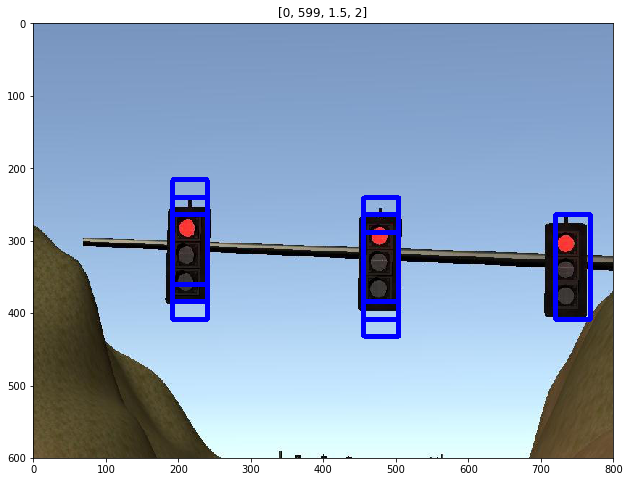

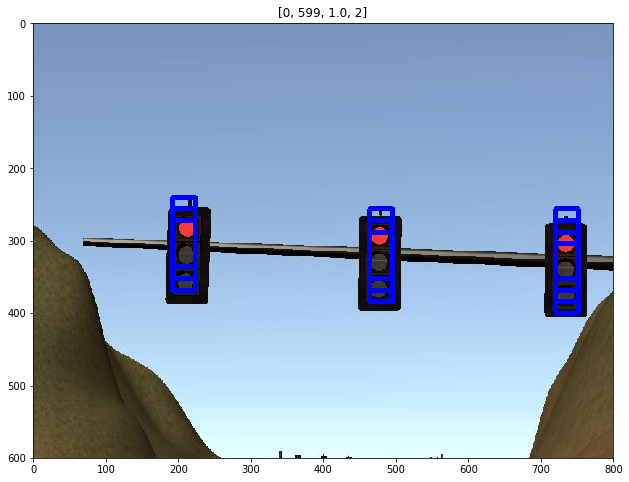

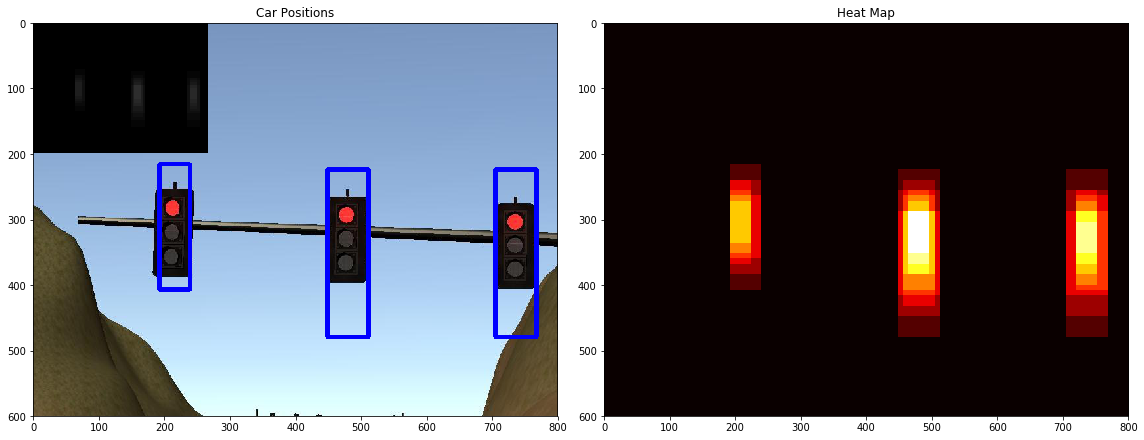

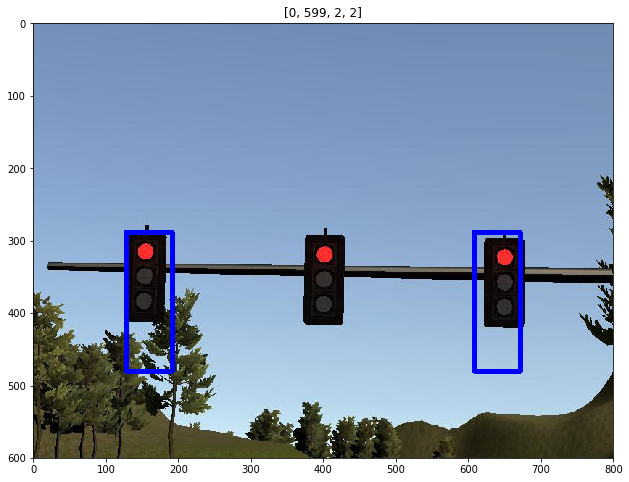

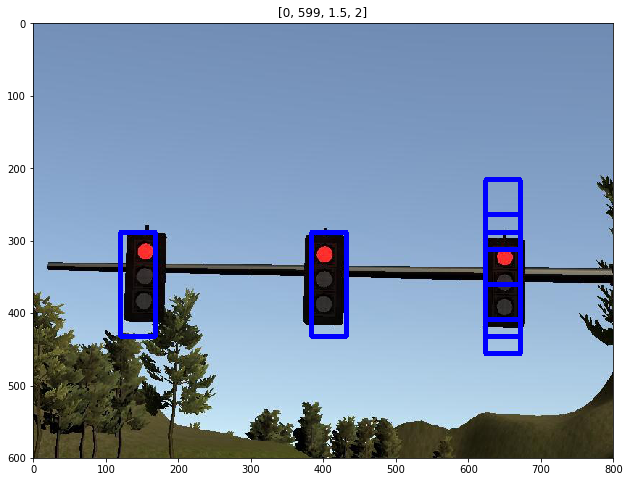

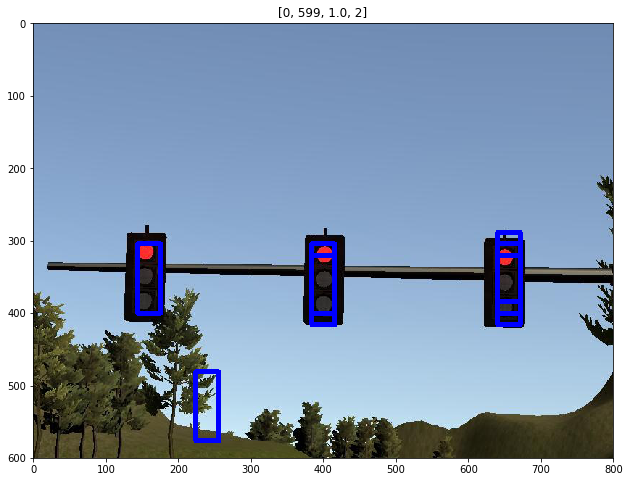

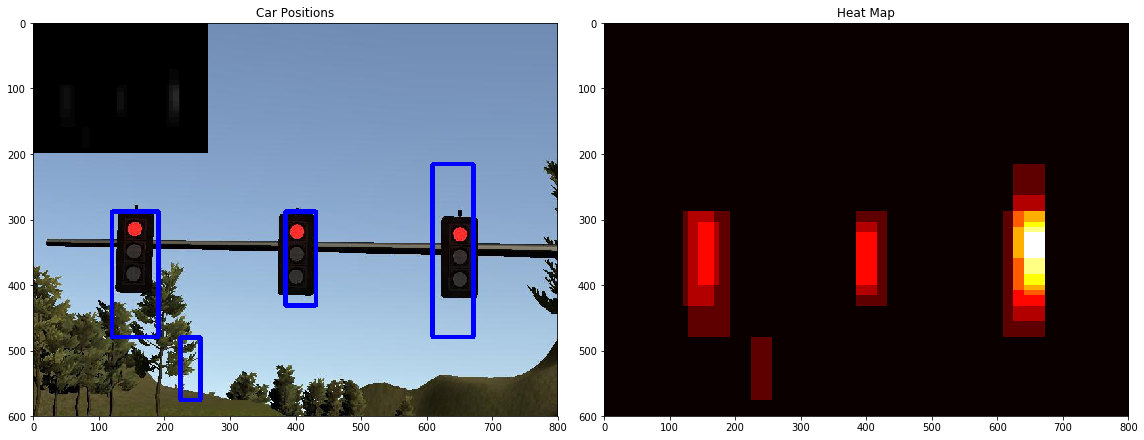

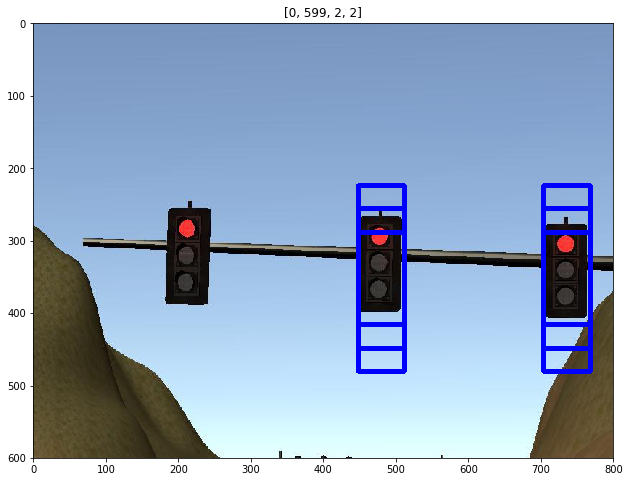

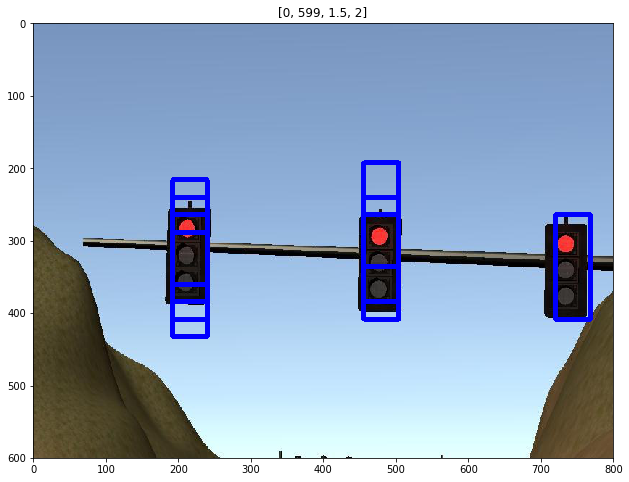

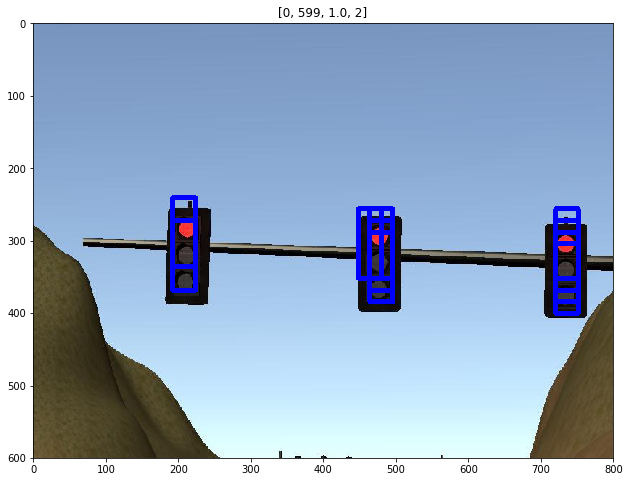

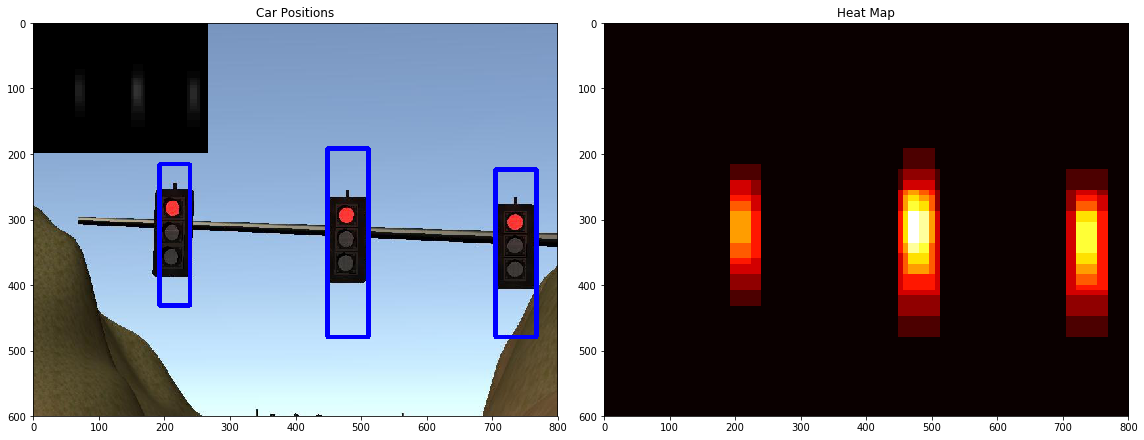

In [20]:
import glob

ti = []

for fname in glob.iglob("test_images_large/*"):
    i = plt.imread(fname)
    ti.append(i)
    
for i in ti:
    process_image(i, threshold = 15, detector_params=detector_params, vis=True)